# Purpose of this simulation


In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
import numpy as np
from weights import *
import pickle 

import os

# so that we write in latex
from matplotlib import rc
from weights_linear_regression import calc_R2_with_sim_C
# rc('font', **{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
from afs_files import load_feature_selection_files
from afs_plotting import subplots_with_labels

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('paper')

save_to_gdrive = False # this is done through the gdrive's mapping to the local file system
gdrive_directory = '/home/aolab/gdrive/Projects/Feature Selection/Figures/'
dpi_value = 300

error_bar_method = "sem" # "std" or "sem"

# ideas

In [2]:


data_dump_folder = \
'/home/aolab/sijia/data/figure2_simulation_setup/'

ROUND_DECIMALS = 3


random_seed = 0
n_neurons = 128
s = 1.0

# clda setup 
rho = 0.5
batch_len = 100
feature_selection_method = "full"
encoder_change_mode = "same"
# encoder_change_mode = "change_to_zeros"

noises = [32]
fixed_noise_level = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3

norm_var_2 = [mean_first_peak, mean_second_peak]
mean_second_peaks = [50, 100]

# feature_selection_method 
FEATURE_SELECTOR_TYPE = "full"
exp_conds = []



exp_conds = [f'{FEATURE_SELECTOR_TYPE}_{s}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_{encoder_change_mode}'\
            for mean_second_peak in mean_second_peaks]

print(data_dump_folder)
print(exp_conds)

/home/aolab/sijia/data/figure2_simulation_setup/
['full_1.0_0_noise_32_128_50_3_clda_rho_0.5_batchlen_100_same', 'full_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_same']


In [3]:

(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 2 number of experiments


In [4]:
feature_weights_all = [exp_data_all[i]['feature_selection']['feature_weights'] for i in range(len(exp_data_all))]

len(feature_weights_all)


2

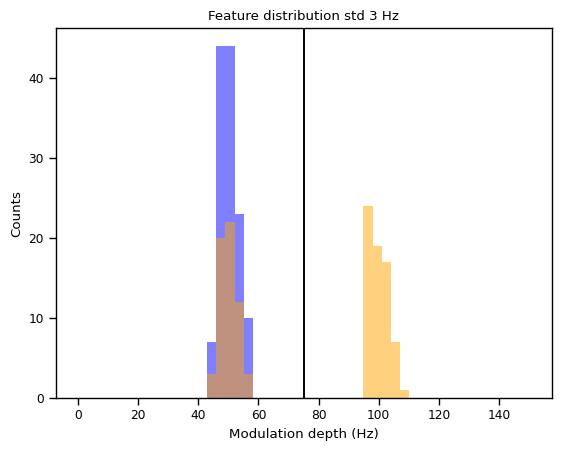

In [5]:
# plot the histogram of the feature weights

colors = ['b', 'orange']

fig_weight, ax_weight = plt.subplots()

std = 3

bins = np.linspace(0, 150, 50)

for feature_weights, c in zip(feature_weights_all, colors):

    ax_weight.hist(feature_weights, bins, color = c, label = f'{std} Hz', alpha = 0.5 )
    ax_weight.axvline(x = 75, color = 'k')
    ax_weight.set_xlabel('Modulation depth (Hz)')
    ax_weight.set_ylabel('Counts')
    ax_weight.set_title(f'Feature distribution std {std} Hz')
    
fig_weight.show()

# Check feature selection strategies

## Plot selected features across feature selection methods

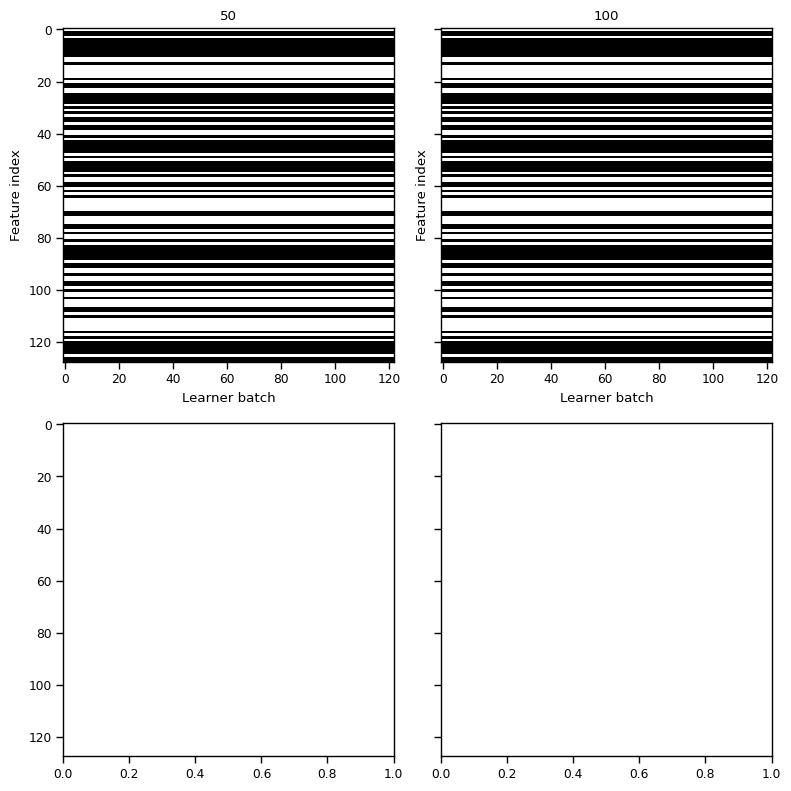

In [6]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 2, 
                                                    sharey = True,
                                                    figsize = (8, 8))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(mean_second_peaks[i] )

    fig_feat_activity.tight_layout()

plt.show()


# Behaviour comparision

## count how many rewards

In [7]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    
    
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)
    
    # print(num_rewards, reward_rate, window_time_stamps)


window_stamps_all_gap = np.array(window_time_stamps_all)
reward_rate_all_gap = np.array(reward_rate_all) 

reward_rate_all_gap = reward_rate_all_gap.reshape((NUM_EXP,-1))
window_stamps_all_gap = window_stamps_all_gap.reshape((NUM_EXP,-1))

total_rewards_all_gap = np.array(total_rewards_all)



Text(0, 0.5, 'Reward rate (rewards/min)')

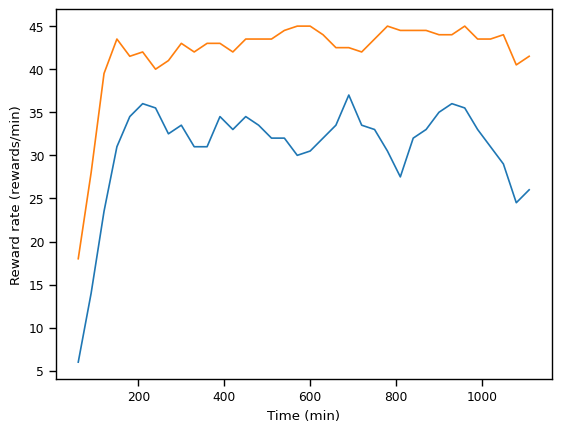

In [8]:
colors = ['blue', 'orange', 'red']

plt.plot( window_time_stamps, reward_rate_all_gap.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')


## Calculate the relvance

In [9]:
R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    intended_velocities = intended_kin[:,(X_VEL_STATE, Y_VEL_STATE, CONST_STATE), :]
    
    # get C_mat
    feature_selection_data = exp_data_all[exp_index]['feature_selection']
    C_mat = feature_selection_data["C_mat"]
    feat_set = feature_selection_data["feat_set"]
    
    # calculate R_2 over batches
    R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, intended_velocities, C_mat, feat_set, debug = False)
    
    #save  the results
    R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_gap = R_2_over_batches_all_exp.T

0
1


## Plot the cursor trajectories

In [10]:
from afs_plotting import get_all_cursor_trajectories,plot_cursor_trajectories

start_codes = range(17, 25)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)


# print how many trials for each condition
for c in cursor_trajectories_list:print(len(c))


range(17, 25)
635
830


In [11]:
def plot_cursor_trajectories(cursor_trajectories, exp_data, exp_metadata, 
                             just_the_targets = False,
                             color_to_closest_target = True,
                             ax = None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['bmi3d_trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)

    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    if color_to_closest_target:
        # get the last point of the cursor trajectory
        cursor_trajectories_last_point = [c[-1] for c in cursor_trajectories]
        cursor_trajectories_last_point = np.array(cursor_trajectories_last_point)

        # generate a label for each cursor trajectory closed to one of the targets
        cursor_trajectories_matrix = np.repeat(cursor_trajectories_last_point[ :,np.newaxis,:], 
                                            len(unique_targets), 
                                            axis = 1)
        unique_targets_matrix = np.repeat(unique_targets[np.newaxis, :, :], len(cursor_trajectories_last_point), axis = 0)

        # calculate the distance between the last point of the cursor trajectory and the targets
        distance = np.linalg.norm(cursor_trajectories_matrix - unique_targets_matrix, axis = 2)
        closest_target_index = np.argmin(distance, axis = 1)

        colors = sns.color_palette("dark:salmon_r", n_colors = len(unique_targets))


        # sns.color_palette("dark:salmon_r", as_cmap=True)
        if not just_the_targets:
            aopy.visualization.color_trajectories(cursor_trajectories, closest_target_index, colors,
                                                bounds = bounds, ax = ax)
    else:
        if not just_the_targets:
            aopy.visualization.plot_trajectories(cursor_trajectories, None, None,
                                                bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, 
                                    bounds = bounds, ax = ax)

    return ax

635
830


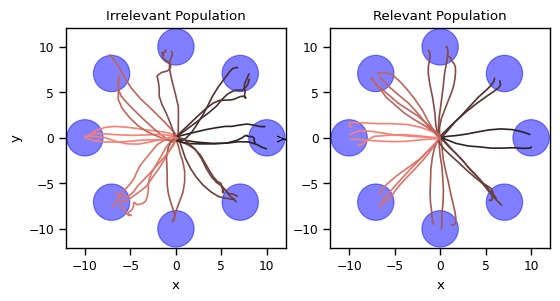

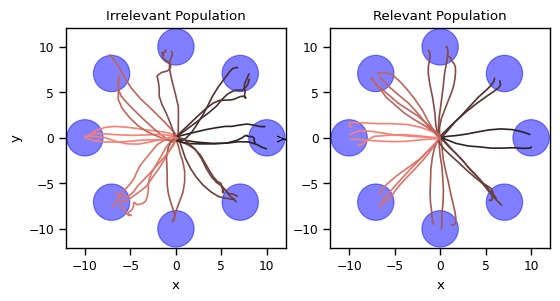

In [12]:
NUM_EXP = len(exp_data_all)

fig, axes = plt.subplots(1, NUM_EXP ,figsize=(6.25,
                                            3.25))

LAST_NUMBER_OF_TRIALS = 24
axes_titles = ['Irrelevant Population', 'Relevant Population']

for i,(ax, t) in enumerate(zip(axes, axes_titles)):
    print(len(cursor_trajectories_list[i]))
    plot_cursor_trajectories(cursor_trajectories_list[i][-LAST_NUMBER_OF_TRIALS:], 
                             exp_data_all[i], exp_metadata_all[i], 
                             ax = ax)
    ax.set_title(t) 

fig

## Plot a summary figure

/tmp/ipykernel_2274379/231950729.py:53: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


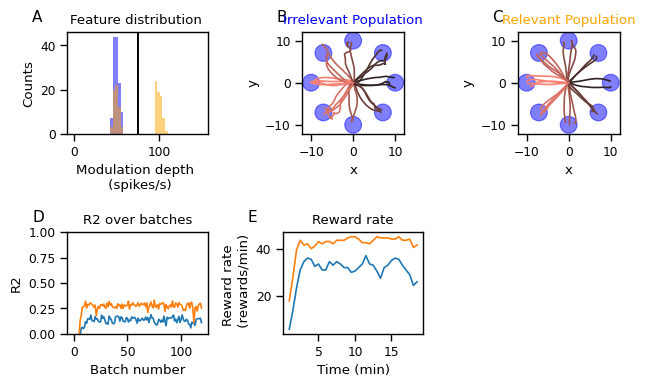

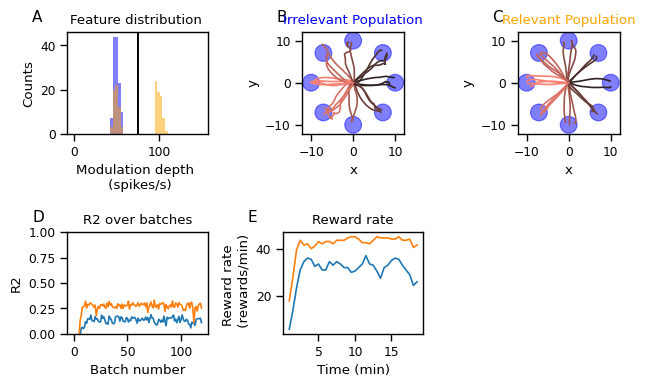

In [13]:
colors = ['b', 'orange']
# fig, axes = plt.subplots(2, 3, figsize=(6.5, 4))

fig, axes = subplots_with_labels(2, 3,
                                      figsize=(6.5,4),
                                      constrained_layout=True)



# First subplot
std = 3
bins = np.linspace(0, 150, 50)
axs = axes[0,0]

for feature_weights, c in zip(feature_weights_all, colors):
    axs.hist(feature_weights, bins, color=c, label=f'{std} Hz', alpha=0.5)
    axs.axvline(x=75, color='k')
    axs.set_xlabel('Modulation depth \n (spikes/s)')
    axs.set_ylabel('Counts')
    axs.set_title(f'Feature distribution ')

# the next two plots, we plot the trajectories
trajectory_axes = axes[0,1:]
LAST_NUMBER_OF_TRIALS = 24
axes_titles = ['Irrelevant Population', 'Relevant Population']
axes_title_colors = ['b', 'orange']



for i,(ax, t) in enumerate(zip(trajectory_axes, axes_titles)):
    plot_cursor_trajectories(cursor_trajectories_list[i][-LAST_NUMBER_OF_TRIALS:], 
                             exp_data_all[i], exp_metadata_all[i], 
                             ax = ax)
    ax.set_title(t, color = axes_title_colors[i])

axs = axes[1,:]

# Second subplot
axs[0].plot(R_2_over_batches_all_exp.T)
axs[0].set_title('R2 over batches')
axs[0].set_xlabel('Batch number')
axs[0].set_ylabel('R2')
axs[0].set_ylim([0, 1])

# Third subplot
axs[1].plot(window_time_stamps /60, reward_rate_all_gap.T )
axs[1].set_xlabel('Time (min)')
axs[1].set_ylabel('Reward rate \n (rewards/min)')
axs[1].set_title('Reward rate')

axs[2].set_visible(False) 

fig.tight_layout()
fig

### Save to gdrive

In [14]:
if save_to_gdrive:
    # pdf format
    fig.savefig(gdrive_directory + 'figure2a_full_feature_selection.pdf', dpi = dpi_value)

    # png format
    fig.savefig(gdrive_directory + 'figure2a_full_feature_selection.png', dpi = dpi_value)

    # svg format
    fig.savefig(gdrive_directory + 'figure2a_full_feature_selection.svg', dpi = dpi_value)


### we plot an empty grid with only targets for illustrating intended velocity

/tmp/ipykernel_2274379/3989470887.py:58: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


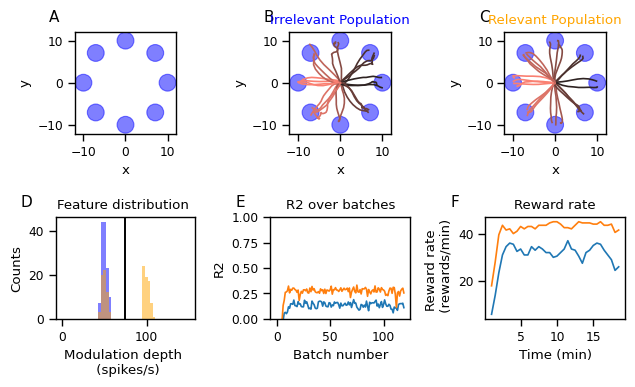

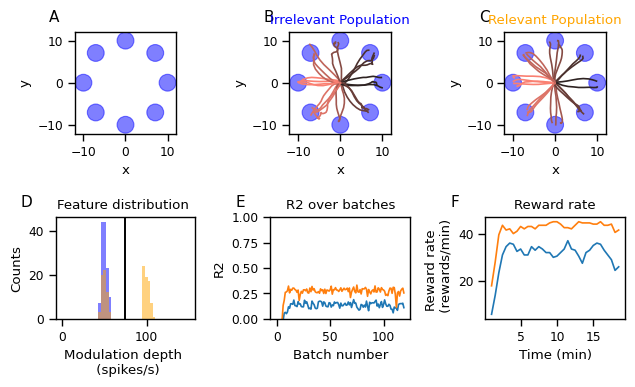

In [15]:
colors = ['b', 'orange']
# fig, axes = plt.subplots(2, 3, figsize=(6.5, 4))

fig, axes = subplots_with_labels(2, 3,
                                      figsize=(6.5,4),
                                      constrained_layout=True)


i = 0
# en ampty grid with only the targets
plot_cursor_trajectories(cursor_trajectories_list[i][-LAST_NUMBER_OF_TRIALS:], 
                            exp_data_all[i], exp_metadata_all[i], 
                            just_the_targets=True,
                            ax = axes[0,0])
# the next two plots, we plot the trajectories
trajectory_axes = axes[0,1:]
LAST_NUMBER_OF_TRIALS = 24
axes_titles = ['Irrelevant Population', 'Relevant Population']
axes_title_colors = ['b', 'orange']

for i,(ax, t) in enumerate(zip(trajectory_axes, axes_titles)):
    plot_cursor_trajectories(cursor_trajectories_list[i][-LAST_NUMBER_OF_TRIALS:], 
                             exp_data_all[i], exp_metadata_all[i], 
                             ax = ax)
    ax.set_title(t, color = axes_title_colors[i])


# First subplot
std = 3
bins = np.linspace(0, 150, 50)
axs = axes[1,0]

for feature_weights, c in zip(feature_weights_all, colors):
    axs.hist(feature_weights, bins, color=c, label=f'{std} Hz', alpha=0.5)
    axs.axvline(x=75, color='k')
    axs.set_xlabel('Modulation depth \n (spikes/s)')
    axs.set_ylabel('Counts')
    axs.set_title(f'Feature distribution ')




axs = axes[1,1:]
# Second subplot
axs[0].plot(R_2_over_batches_all_exp.T)
axs[0].set_title('R2 over batches')
axs[0].set_xlabel('Batch number')
axs[0].set_ylabel('R2')
axs[0].set_ylim([0, 1])

# Third subplot
axs[1].plot(window_time_stamps /60, reward_rate_all_gap.T )
axs[1].set_xlabel('Time (min)')
axs[1].set_ylabel('Reward rate \n (rewards/min)')
axs[1].set_title('Reward rate')


fig.tight_layout()
fig

In [16]:
if save_to_gdrive:
    # pdf format
    fig.savefig(gdrive_directory + 'figure2a_full_feature_selection_with_blank_grid.pdf', dpi = dpi_value)

    # png format
    fig.savefig(gdrive_directory + 'figure2a_full_feature_selection_with_blank_grid.png', dpi = dpi_value)

    # svg format
    fig.savefig(gdrive_directory + 'figure2a_full_feature_selection_with_blank_grid.svg', dpi = dpi_value)

# Analyze the encoder shuffle result

In [17]:


data_dump_folder = \
'/home/aolab/sijia/data/figure2_simulation_setup/'

ROUND_DECIMALS = 3


random_seed = 0
n_neurons = 128
s = 1.0

# clda setup 
rho = 0.5
batch_len = 100
feature_selection_method = "full"
# encoder_change_mode = "swap_top_and_bottom"
encoder_change_mode = "shuffle_rows"

noises = [32]
fixed_noise_level = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 110
std_of_peaks = 3

norm_var_2 = [mean_first_peak, mean_second_peak]

# feature_selection_method 
FEATURE_SELECTOR_TYPE = "full"
init_feat_first_or_last_all = ['first', "last"]
init_feat = "first"
exp_conds = []

feature_selection_schemes = ['Constant', 'Oracle']

random_seeds = range(10)

error_bar_method = "sem" # "std" or "sem"

for random_seed in random_seeds:


    exp_conds_full = [f'{FEATURE_SELECTOR_TYPE}_{s}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_init_{init_feat}_{encoder_change_mode}']
    exp_conds_oracle = [f'Oracle_{1.0}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_{encoder_change_mode}']

    exp_conds += exp_conds_full
    exp_conds += exp_conds_oracle

print(data_dump_folder)
print(feature_selection_schemes)
for e in exp_conds:print(e)

/home/aolab/sijia/data/figure2_simulation_setup/
['Constant', 'Oracle']
full_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_first_shuffle_rows
Oracle_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_shuffle_rows
full_1.0_1_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_first_shuffle_rows
Oracle_1.0_1_noise_32_128_110_3_clda_rho_0.5_batchlen_100_shuffle_rows
full_1.0_2_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_first_shuffle_rows
Oracle_1.0_2_noise_32_128_110_3_clda_rho_0.5_batchlen_100_shuffle_rows
full_1.0_3_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_first_shuffle_rows
Oracle_1.0_3_noise_32_128_110_3_clda_rho_0.5_batchlen_100_shuffle_rows
full_1.0_4_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_first_shuffle_rows
Oracle_1.0_4_noise_32_128_110_3_clda_rho_0.5_batchlen_100_shuffle_rows
full_1.0_5_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_first_shuffle_rows
Oracle_1.0_5_noise_32_128_110_3_clda_rho_0.5_batchlen_100_shuffle_rows
full_1.0_6_noise_32_12

In [18]:
from afs_files import load_feature_selection_files, load_and_convert_clda_pickle_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
clda_data_all = load_and_convert_clda_pickle_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 20 number of experiments


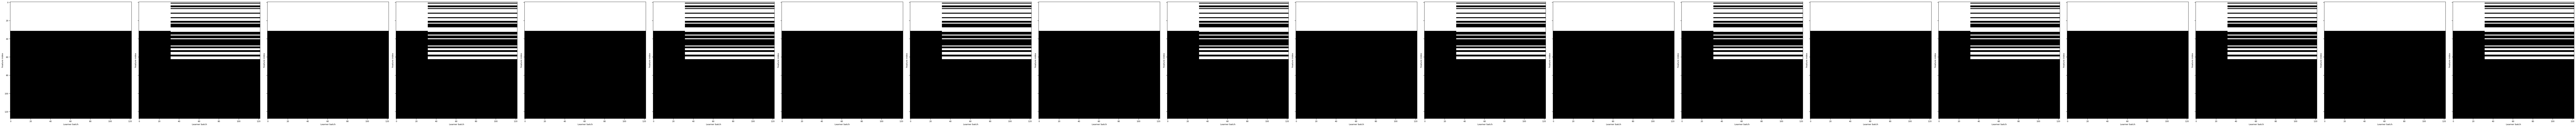

In [19]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(1, num_columns, 
                                                    sharey = True,
                                                    figsize = (8*num_columns, 8))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        # a.set_title(init_feat_first_or_last_all[i])

    fig_feat_activity.tight_layout()

plt.show()

In [20]:
threshold = 90

feature_weights = exp_data_all[0]['feature_selection']['feature_weights']
exp_data_all[0]['feature_selection'].keys()
new_sim_c = exp_data_all[0]['feature_selection']['new_sim_c']
sim_c = exp_data_all[0]['feature_selection']['sim_C']

good_features_initial = (np.linalg.norm(sim_c, axis=1) >threshold)
good_features_after_shuffled = (np.linalg.norm(new_sim_c, axis=1) >threshold)


nnum_of_repeats_before,  num_of_repeats_after= 30, 30


old_features_before_shuffled_repeat = np.repeat(good_features_initial[:, np.newaxis],
                                                nnum_of_repeats_before, axis = 1)
new_features_after_shuffled_repeat = np.repeat(good_features_after_shuffled[:, np.newaxis],
                                                num_of_repeats_after, axis = 1)

encoder_weight_change = np.concatenate((old_features_before_shuffled_repeat,
                                        new_features_after_shuffled_repeat), axis = 1)

encoder_weight_change.shape

(128, 60)

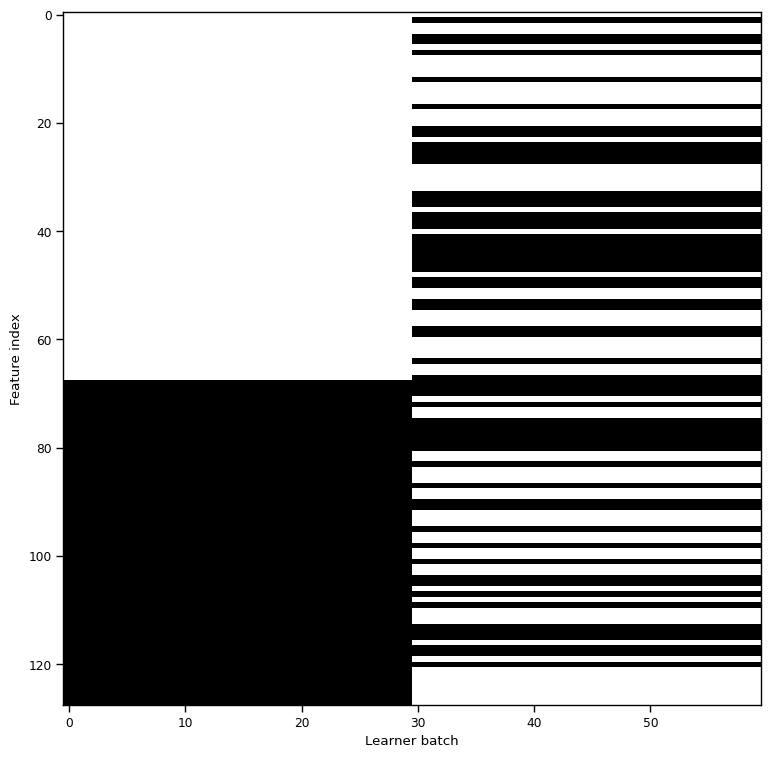

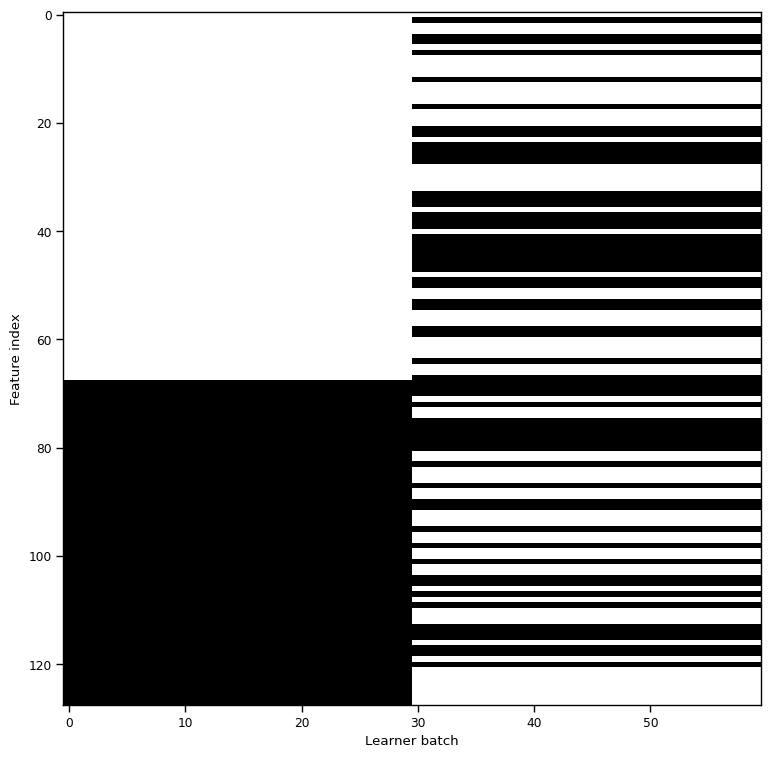

In [21]:
summary_figure, summary_axes = plt.subplots(figsize = (9, 9))
plot_feature_selection(encoder_weight_change.T, ax = summary_axes)
summary_figure

## let's calculate the feature smoothness

In [22]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

selected_feature_batches = [exp_data_all[i]['feature_selection']['feat_set'] for i in range(len(exp_data_all))]

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())

num_features_exp_by_batch = np.array(num_features_exp_by_batch)
selected_feature_batches = np.array(selected_feature_batches)



print(selected_feature_batches.shape)

selected_features_conds_by_feature_batches = np.moveaxis(selected_feature_batches, 1, 2)


smoothness_conds_by_batch = \
calculate_feature_smoothness_multiple_conditions(selected_features_conds_by_feature_batches, 
                                                 mode = "incremental")


if len(feature_selection_schemes) <= len(exp_conds):
    # then we need to do reshape and median
    # assume that len(random_seeds) x len(smooth) = total number of exp
    smoothness_conds_by_batch_reshape = np.reshape(smoothness_conds_by_batch,
                                             (len(random_seeds), len(feature_selection_schemes), -1))
    
    # # after reshape,  we median along the random and first axiss
    smoothness_conds_by_batch_median = np.median(smoothness_conds_by_batch_reshape, 
                                        axis = 0)
    
    # then depending on the error_bar_method, we calculate the error bars
    if error_bar_method == 'sem':
        smoothness_conds_by_batch_sem = 1.25 * np.std(smoothness_conds_by_batch_reshape, axis = 0) / np.sqrt(len(random_seeds))

        smoothness_conds_by_batch_25 = smoothness_conds_by_batch_median - smoothness_conds_by_batch_sem
        smoothness_conds_by_batch_75 = smoothness_conds_by_batch_median + smoothness_conds_by_batch_sem
        print("used the sem to calulate the error bar in smoothness")

    elif error_bar_method == 'percentiles':
        smoothness_conds_by_batch_error = np.percentile(smoothness_conds_by_batch_reshape, [25, 75], axis = 0)
    else:
        raise ValueError('error bar method not recognized')


    # print out a message
    print("we reshaped the smoothness array")

    # # averaging across the random seeds axis, the first axis
    smoothness_conds_by_batch = np.median(smoothness_conds_by_batch_reshape, axis = 0)

print(smoothness_conds_by_batch.shape)
print(smoothness_conds_by_batch_median.shape)
print(smoothness_conds_by_batch_25.shape)
print(smoothness_conds_by_batch_75.shape)

(20, 122, 128)


used the sem to calulate the error bar in smoothness
we reshaped the smoothness array
(2, 121)
(2, 121)
(2, 121)
(2, 121)


## let's calculate the reward rate

In [23]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(len(exp_data_all)):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    
    window_time_stamps = window_time_stamps / fps
    
    reward_rate_all.append(reward_rate )
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)
    
    # print(num_rewards, reward_rate, window_time_stamps)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
# if the num of experiemnt is larger than the len of smoothness array, then we need to reshape and median
if len(feature_selection_schemes) <= len(exp_conds):

    print("before reshape", reward_rate_all.shape  )
    # then we need to do reshape and median
    # assume that len(random_seeds) x len(smooth) = total number of exp
    reward_rate_all = np.reshape(reward_rate_all,
                                             (len(random_seeds), len(feature_selection_schemes), -1))
    
    # # after reshape,  we median along the random and first axiss
    reward_rate_all_median = np.median(reward_rate_all, axis = 0)

    # print out a message
    # calculate the median across the random seeds, and the 25th, 75th percentiles
    # calculate the error bars based on the error_bar_method
    if error_bar_method == "sem":
        reward_rate_all_sem = np.std(reward_rate_all, axis = 0) / np.sqrt(len(random_seeds))
        reward_rate_all_25 = reward_rate_all_median - reward_rate_all_sem
        reward_rate_all_75 = reward_rate_all_median + reward_rate_all_sem
        print("used the sem method")
    elif error_bar_method == "percentiles":
        reward_rate_all_25, reward_rate_all_75 = np.percentile(reward_rate_all, [25, 75], axis = 0)
        print("used the percentiles method")

    reward_rate_all = np.median(reward_rate_all, axis = 0)

window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)

print(reward_rate_all.shape)
print(reward_rate_all.shape)
print(reward_rate_all_25.shape, reward_rate_all_75.shape)

before reshape (20, 36)
used the sem method
(2, 36)
(2, 36)
(2, 36) (2, 36)


## let's calculate the relevance

In [24]:
R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    # intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    # spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    try:
        intended_kin = clda_data_all[exp_index]['intended_kin']
        spike_counts_batch = clda_data_all[exp_index]['spike_counts_batch']

        intended_kin = np.array(intended_kin)

        intended_velocities = intended_kin[:, [X_VEL_STATE, Y_VEL_STATE, CONST_STATE],:]
        # # get C_mat
        feature_selection_data = exp_data_all[exp_index]['feature_selection']
        C_mat = feature_selection_data["C_mat"]
        feat_set = feature_selection_data["feat_set"]

        # # calculate R_2 over batches
        R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, 
                                            intended_velocities,
                                            C_mat, feat_set, debug = False)
        
        # #save  the results
        R_2_over_batches_all_exp.append(R_2_over_batches)
        
        
    except Exception as e:
        print(f"KeyError: {e}not found in data.")
    
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_shuffle = R_2_over_batches_all_exp

# calculate the median and the 25th and 75th percentiles for the relevance of the features
R_2_over_batches_all_exp_reshape = R_2_over_batches_all_exp.reshape((len(random_seeds), len(feature_selection_schemes), -1))
if len(feature_selection_schemes) <= len(exp_conds):
    R_2_over_batches_all_exp_median = np.median(R_2_over_batches_all_exp_reshape, axis = 0)
    if error_bar_method == "sem":
        R_2_over_batches_all_exp_sem = 1.25 * np.std(R_2_over_batches_all_exp_reshape, axis = 0) / np.sqrt(len(random_seeds))
        R_2_over_batches_all_exp_25 = R_2_over_batches_all_exp_median - R_2_over_batches_all_exp_sem
        R_2_over_batches_all_exp_75 = R_2_over_batches_all_exp_median + R_2_over_batches_all_exp_sem
    elif error_bar_method == "percentiles":
        R_2_over_batches_all_exp_25, R_2_over_batches_all_exp_75 = np.percentile(R_2_over_batches_all_exp_reshape, [25, 75], axis = 0)
    else:
        raise ValueError('error bar method not recognized')
    
    R_2_over_batches_all_exp = R_2_over_batches_all_exp_median

# print out the shapes
print(R_2_over_batches_all_exp.shape)
print(R_2_over_batches_all_exp_25.shape)
print(R_2_over_batches_all_exp_75.shape)


(2, 120)
(2, 120)
(2, 120)


## make a summary figure for the shuffling case

/tmp/ipykernel_2274379/2562017134.py:52: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


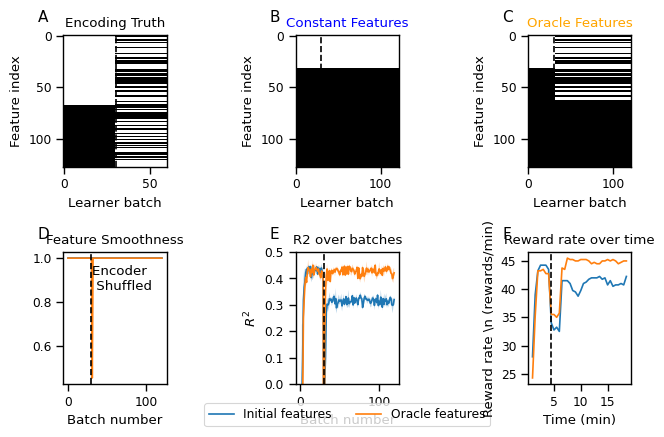

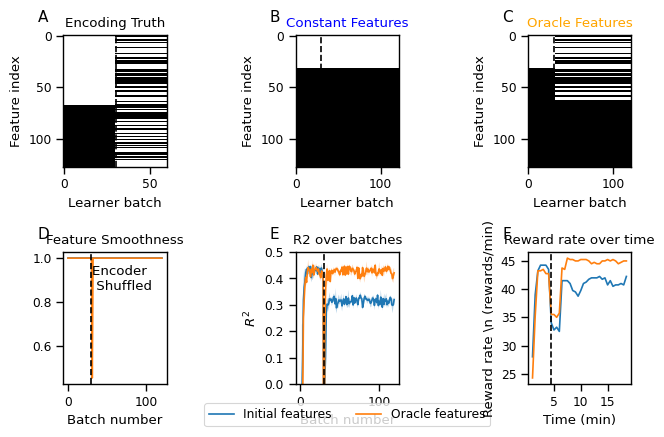

In [25]:
# make a 2 by 3 figure
fig, axs = subplots_with_labels(2, 3, figsize=(6.5, 4.5))

# first row are the conditions
axs[0,0].set_title('Encoding Truth')
axs[0,1].set_title('Constant Features', color = 'blue')
axs[0,2].set_title('Oracle Features', color = 'orange')

plot_feature_selection(encoder_weight_change.T, ax = axs[0,0])
plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'], ax = axs[0,1])
plot_feature_selection(exp_data_all[1]['feature_selection']['feat_set'], ax = axs[0,2])

# draw dotted lines to separate the conditions
axs[0,0].axvline(x = 30, color = 'k', linestyle='--')
axs[0,1].axvline(x = 30, color = 'k', linestyle='--')
axs[0,2].axvline(x = 30, color = 'k', linestyle='--')


# second row are the results

axs[1,0].set_title("Feature Smoothness")
axs[1,1].set_title("R2 over batches")
axs[1,2].set_title("Reward rate over time")

axs[1,0].plot(smoothness_conds_by_batch.T)
axs[1,0].set_xlabel('Batch number')
axs[1,0].text(30.5, 0.9, 'Encoder \n Shuffled', ha='left', va='top',
               transform=axs[1,0].get_xaxis_transform())
axs[1,0].axvline(x = 30, color = 'k', linestyle='--')

axs[1,1].plot(R_2_over_batches_all_exp_median.T)
# fill in between the 25th and 75th percentiles
for i in range(len(R_2_over_batches_all_exp_25)):
    axs[1,1].fill_between(range(len(R_2_over_batches_all_exp_median.T)), 
                          R_2_over_batches_all_exp_25[i].T, 
                          R_2_over_batches_all_exp_75[i].T, alpha = 0.3)

axs[1,1].set_title('R2 over batches')
axs[1,1].set_xlabel('Batch number')
axs[1,1].axvline(x = 30, color = 'k', linestyle='--')
axs[1,1].set_ylabel(r'$R^2$')
axs[1,1].set_ylim([0, 0.5])
axs[1,1].legend(['Initial features', 'Oracle features'], 
                loc='upper center', 
                bbox_to_anchor=(0.5, -0.1), ncol=2)

axs[1,2].plot( window_time_stamps, reward_rate_all.T)
axs[1,2].set_xlabel('Time (min)')
axs[1,2].set_ylabel(r'Reward rate \n (rewards/min)')
axs[1,2].axvline(x = 4.5, color = 'k', linestyle='--')

fig.tight_layout()
fig.show()
fig

## PLOT re arrange the figure to make it look super nice

/tmp/ipykernel_2274379/212699445.py:62: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


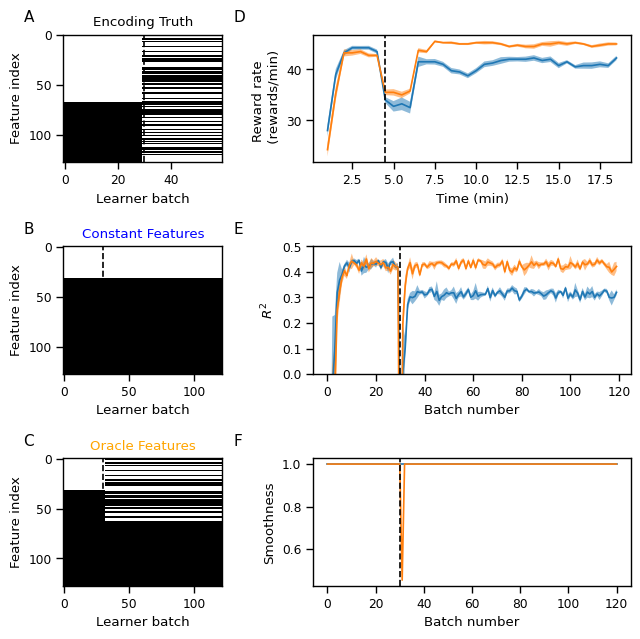

In [28]:
# make a 3 by 2 figure, and the second column will take the twice as much space as the first column
fig, axs = subplots_with_labels(3, 2, figsize=(6.5, 6.5), label_directions= 'col_first',
                                gridspec_kw={'width_ratios': [1, 2]})

# first column are the conditions
axs[0,0].set_title('Encoding Truth')
axs[1,0].set_title('Constant Features', color = 'blue')
axs[2,0].set_title('Oracle Features', color = 'orange')

plot_feature_selection(encoder_weight_change.T, ax = axs[0,0])
plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'], ax = axs[1,0])
plot_feature_selection(exp_data_all[1]['feature_selection']['feat_set'], ax = axs[2,0])

# draw dotted lines to separate the conditions
axs[0,0].axvline(x = 30, color = 'k', linestyle='--')
axs[1,0].axvline(x = 30, color = 'k', linestyle='--')
axs[2,0].axvline(x = 30, color = 'k', linestyle='--')

# second column are the results

# plot of the smoothness of the features using 25th and 75th percentiles
# and fill in between the 25th and 75th percentiles
axs[2,1].plot(smoothness_conds_by_batch_median.T)

for i in range(smoothness_conds_by_batch_median.shape[0]):
    axs[2,1].fill_between(range(smoothness_conds_by_batch_median.shape[1]),
                          smoothness_conds_by_batch_25[i],
                          smoothness_conds_by_batch_75[i],
                          alpha = 0.5)

axs[2,1].set_xlabel('Batch number')
# axs[0,1].text(30.5, 0.9, 'Encoder \n Shuffled', ha='left', va='top',
#                transform=axs[0,1].get_xaxis_transform())
axs[2,1].axvline(x = 30, color = 'k', linestyle='--')
axs[2,1].set_ylabel('Smoothness')

axs[1,1].plot(R_2_over_batches_all_exp_median.T)

for i in range(R_2_over_batches_all_exp_25.shape[0]):
    axs[1,1].fill_between(range(R_2_over_batches_all_exp_median.shape[1]), 
                          R_2_over_batches_all_exp_25[i],
                          R_2_over_batches_all_exp_75[i],
                          alpha = 0.5)

axs[1,1].set_xlabel('Batch number')
axs[1,1].axvline(x = 30, color = 'k', linestyle='--')
axs[1,1].set_ylabel(r'$R^2$')
axs[1,1].set_ylim([0, 0.5])

axs[0,1].plot( window_time_stamps, reward_rate_all.T)
# fill in between with the 25th and 75th percentiles
for i in range(reward_rate_all.shape[0]):
    axs[0,1].fill_between(window_time_stamps,
                          reward_rate_all_25[i],
                          reward_rate_all_75[i],
                          alpha = 0.5)

axs[0,1].set_xlabel('Time (min)')
axs[0,1].set_ylabel('Reward rate \n (rewards/min)')
axs[0,1].axvline(x = 4.5, color = 'k', linestyle='--')

fig.tight_layout()



### save the plotting data

In [33]:
## save the reward rate to data_dump_folder
# make a data dict to save the reward rate and the smooth features

oracle_data_dict = {'reward_rate_all': reward_rate_all,
            'window_stamps_all': window_stamps_all,
            'smoothness_conds_by_batch': smoothness_conds_by_batch
            }
with open(os.path.join(data_dump_folder, 
                        'oracle_data_dict.pkl'), 'wb') as f:
    pickle.dump(oracle_data_dict, f)


### save to gdrive

In [27]:
save_to_gdrive = True # this is done through the gdrive's mapping to the local file system
if save_to_gdrive:
    # pdf format
    fig.savefig(gdrive_directory + 'figure2b_encoder_swapping.pdf', dpi = dpi_value)

    # png format
    fig.savefig(gdrive_directory + 'figure2b_encoder_swapping.png', dpi = dpi_value)

    # svg format
    fig.savefig(gdrive_directory + 'figure2b_encoder_swapping.svg', dpi = dpi_value)
